In [1]:
%pip install pandas numpy matplotlib seaborn nltk scikit-learn tensorflow

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize



from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

Note: you may need to restart the kernel to use updated packages.


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kisha\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# Load datasets
true_df = pd.read_csv('../data/True.csv')
fake_df = pd.read_csv('../data/Fake.csv')

# Add labels: 1 for True, 0 for Fake
true_df['label'] = 1
fake_df['label'] = 0

# Combine datasets
data = pd.concat([true_df, fake_df], ignore_index=True)
data = data.sample(frac=1).reset_index(drop=True)  # Shuffle

# Use title + text
data['content'] = data['title'] + " " + data['text']

In [3]:
data.head()

,title,text,subject,date,label,content
0,Trump says he believes Cuba responsible for at...,WASHINGTON (Reuters) - President Donald Trump ...,politicsNews,"October 16, 2017",1,Trump says he believes Cuba responsible for at...
1,WILL JULIAN ASSANGE BE ASSASSINATED Before He ...,"Besides Trump, no one has a bigger target on h...",politics,"Sep 5, 2016",0,WILL JULIAN ASSANGE BE ASSASSINATED Before He ...
2,Ivanka Just Threw Her Father Under The Campai...,Hours before the third and final presidential ...,News,"October 19, 2016",0,Ivanka Just Threw Her Father Under The Campai...
3,LOVE AT FIRST LEAK! Former “Baywatch” Star Pam...,Julian Assange became a computer hacker in his...,left-news,"Mar 11, 2017",0,LOVE AT FIRST LEAK! Former “Baywatch” Star Pam...
4,U.S. senator insists special counsel won't der...,WASHINGTON (Reuters) - A senior U.S. senator s...,politicsNews,"May 19, 2017",1,U.S. senator insists special counsel won't der...


In [4]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = text.lower()
    text = re.sub(r'\[.*?\]', '', text)
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r'<.*?>+', '', text)
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub(r'\n', ' ', text)
    text = re.sub(r'\w*\d\w*', '', text)
    
    tokens = word_tokenize(text)
    cleaned = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(cleaned)


In [5]:
data['clean_content'] = data['content'].apply(clean_text)

In [6]:
# View sample cleaned text
data[['label', 'clean_content']].tail(10)


,label,clean_content
44888,1,mexico report flag shortcoming fight corruptio...
44889,1,supreme court may take action state assault we...
44890,0,afghanistan forgotten gone u army paratrooper ...
44891,0,republican already planning health care bill f...
44892,0,boom ivanka ’ line ranked amazon bestseller li...
44893,0,helping hillary virginia governor help people ...
44894,0,house intel chair trumprussia fake story “ evi...
44895,1,obama name scalia replacement three week senat...
44896,0,anne frank center savage spicer said hitler ’ ...
44897,0,muslim miss universe contestant ignores compet...


In [7]:
%pip install gensim

from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize


# Tokenize cleaned content
tokenized_content = [word_tokenize(text) for text in data['clean_content']]

# Train Word2Vec model
w2v_model = Word2Vec(sentences=tokenized_content, vector_size=100, window=5, min_count=2, workers=4)




Note: you may need to restart the kernel to use updated packages.


In [8]:
print(w2v_model.wv['india'])  # Example word vector
print(len(w2v_model.wv['india']))  # Should be 100 dimensions


print(f"Vocabulary Size: {len(w2v_model.wv)}")





[-0.9156548  -2.1514251  -0.0508146   0.33626154  0.22672908 -1.3739185
 -0.4421791   0.44854844 -1.245941    1.3748716  -0.80287194  1.1486955
 -0.34246227  0.9090402   2.0634437  -2.906983    0.88439643  0.02060516
  0.03492341 -0.8802724   0.8345457   0.42499357  0.25029856  0.73330474
  0.45569032  0.49909863 -1.4088035  -0.53554535  0.28339934 -1.5840377
 -1.2569674   0.04108375 -1.0238171  -0.41171432 -0.05318083 -0.47967032
  0.24842276  1.1719425   1.8254087   0.9246634  -1.6436632   1.3166904
 -0.01663122  2.3961012  -0.7673899   0.3044944   1.0305581   0.03748165
  1.939341   -2.3805006   1.5168775   1.3261508   1.9817538   0.63796455
 -2.1621919  -1.1291283  -2.6193647   2.5783434  -0.27105898  0.4601767
  0.02040459  1.4155147   0.91621035  2.2620943  -0.75283104  0.03768279
 -0.62433267  0.9023722  -0.07517608  0.6460594  -0.02834919  1.8203721
  0.00642198 -1.3399559   0.23557167  0.11056684 -2.1974092   2.000805
  1.4278129  -2.2863874  -1.5297061  -0.29362124 -0.7103050

In [9]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import pickle

# 1. Define input and labels
X = data['clean_content']
y = data['label']

# 2. Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Fit tokenizer on training text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)




with open("tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)


# 4. Convert text to sequences of integers
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# 5. Check vocabulary size
vocab_size = len(tokenizer.word_index) + 1
print(f"Vocabulary size: {vocab_size}")

# 6. Padding: make all sequences the same length
max_len = 300  # Based on earlier text length plot

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post')


Vocabulary size: 174883


In [10]:
tokenizer.texts_to_sequences("obama say attack police hurt black")

[[39078],
 [2923],
 [],
 [2713],
 [],
 [],
 [16165],
 [],
 [],
 [],
 [],
 [31919],
 [31919],
 [],
 [3918],
 [5757],
 [],
 [4841],
 [39078],
 [4465],
 [],
 [3918],
 [3325],
 [],
 [5409],
 [4],
 [2839],
 [31919],
 [],
 [2923],
 [4465],
 [],
 [3918],
 [5757]]

In [11]:
import numpy as np

embedding_dim = 100  # Same as you used in Word2Vec
vocab_size = len(tokenizer.word_index) + 1

# Initialize embedding matrix with zeros
embedding_matrix = np.zeros((vocab_size, embedding_dim))

# Fill embedding matrix
for word, i in tokenizer.word_index.items():
    if word in w2v_model.wv:  # word is in Word2Vec vocab
        embedding_vector = w2v_model.wv[word]
        embedding_matrix[i] = embedding_vector  # Assign vector to index
    else:
        embedding_matrix[i] = np.random.normal(0, 0.1, embedding_dim)  # optional: random vector for unknowns


In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

model = Sequential()

# 1. Embedding Layer (initialized with Word2Vec vectors)
model.add(Embedding(input_dim=vocab_size,
                    output_dim=embedding_dim,
                    weights=[embedding_matrix],
                    input_length=max_len,
                    trainable=False))  # freeze embeddings

# 2. LSTM Layer
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))


# 3. Dropout to prevent overfitting
model.add(Dropout(0.5))

# 4. Output Layer
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# Print summary
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │    17,488,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,488,300 (66.71 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 17,488,300 (66.71 MB)

In [21]:
from tensorflow.keras.callbacks import EarlyStopping

# Optional: Stop training early if validation accuracy doesn't improve
early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train_pad, y_train,
    epochs=5,
    batch_size=64,
    validation_data=(X_test_pad, y_test),
    callbacks=[early_stop],  # optional
    verbose=1
)


Epoch 1/5
562/562 ━━━━━━━━━━━━━━━━━━━━ 521s 915ms/step - accuracy: 0.8711 - loss: 0.3199 - val_accuracy: 0.9344 - val_loss: 0.2050
Epoch 2/5
562/562 ━━━━━━━━━━━━━━━━━━━━ 500s 891ms/step - accuracy: 0.9345 - loss: 0.2181 - val_accuracy: 0.9527 - val_loss: 0.1696
Epoch 3/5
562/562 ━━━━━━━━━━━━━━━━━━━━ 333s 591ms/step - accuracy: 0.8107 - loss: 0.4083 - val_accuracy: 0.9411 - val_loss: 0.1681
Epoch 4/5
562/562 ━━━━━━━━━━━━━━━━━━━━ 245s 436ms/step - accuracy: 0.9551 - loss: 0.1521 - val_accuracy: 0.9830 - val_loss: 0.0593
Epoch 5/5
562/562 ━━━━━━━━━━━━━━━━━━━━ 241s 430ms/step - accuracy: 0.9771 - loss: 0.0799 - val_accuracy: 0.9902 - val_loss: 0.0360


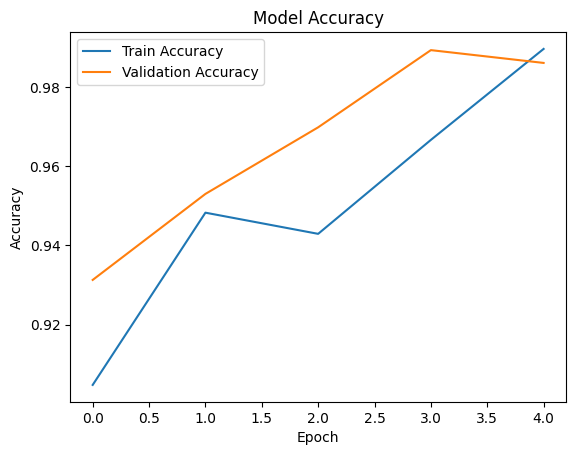

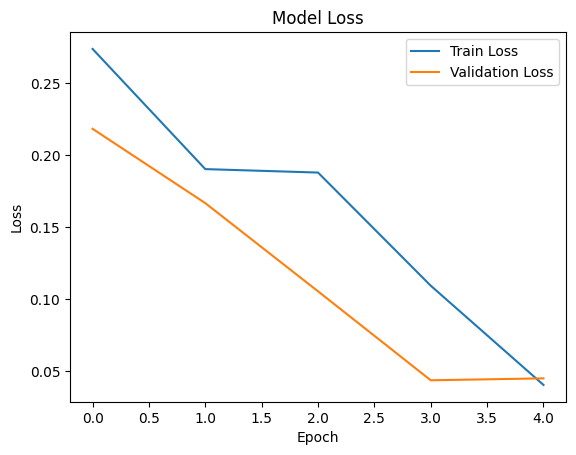

In [14]:
import matplotlib.pyplot as plt

# Accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


In [22]:
loss, accuracy = model.evaluate(X_test_pad, y_test)
print(f"Test Accuracy: {accuracy:.4f}")



    
model.save("fake_news_lstm_model.h5")

281/281 ━━━━━━━━━━━━━━━━━━━━ 15s 52ms/step - accuracy: 0.9907 - loss: 0.0346
Test Accuracy: 0.9902

In [16]:
def predict_news(text):
    # 1. Clean the text (same steps used in training)
    cleaned = clean_text(text)
    
    # 2. Tokenize and pad
    seq = tokenizer.texts_to_sequences([cleaned])
    padded = pad_sequences(seq, maxlen=max_len, padding='post')
    
    # 3. Predict
    pred = model.predict(padded)[0][0]  # gives probability

    # 4. Return label
    if pred >= 0.5:
        return f"✅ Real News (Confidence: {pred:.2f})"
    else:
        return f"❌ Fake News (Confidence: {1 - pred:.2f})"


In [17]:
news = "The Indian Prime Minister announced a new economic policy today."
print(predict_news(news))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step
❌ Fake News (Confidence: 0.99)


In [18]:
predict_news("Breaking: PM resigns due to alien invasion!")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


'❌ Fake News (Confidence: 0.99)'

In [19]:
news_text = "Shocking: NASA confirms sun will explode tomorrow!"
print(predict_news(news_text))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
❌ Fake News (Confidence: 0.99)
